In [5]:
%matplotlib notebook
from astropy.io import ascii
import pickle
import astropy.coordinates as coord
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy
# if you're using colab, you need to mount the drive using these 2 statements and provide the path for the files saved in your google drive.
# from google.colab import drive
# drive.mount('drive/')

In [6]:
class GHRSS:
    def __init__(self):
        self.RA_source = {}
        self.Dec_source = {}
        self.RA_objects = {}
        self.Dec_objects = {}
        self.file_names_sources = []
        self.file_names_objects = []
        self.colors1 = []
        self.colors2 = []
        # colors can be changed here according to the output requirement.
        self.colors_init = ['r', 'g', 'y', 'k', 'violet']
        self.coordinates = 0
        self.coord_ra = 0
        self.coord_dec = 0
        self.coord_l = 0
        self.coord_b = 0
        self.radec = 0
        self.label = []
        self.color_count = 0

    # writes the colors exisiting in list colors1 and colors 2
    def write_colors(self, color_new):
        self.colors2 = iter(cm.Blues(numpy.linspace(0, 1, 6)))
        with open('colors.txt', 'w') as f:
            for c in color_new:
                f.write("%s\n" % c)
        f.close()
        x = str(self.color_count)
#         print(x)
        with open('colors2.txt', 'w') as f1:
            f1.write('%s' % x)
        f1.close()

    def read_colors(self):
        color1 = []
        with open("colors.txt", 'r') as file:
            temp = file.readlines()
            # print(type(temp))
        for i in temp:
            temp2 = i.split('\n')
            color1.append(temp2[0])
        self.colors1 = color1
        self.colors2 = iter(cm.Blues(numpy.linspace(0, 1, 6)))
        with open("colors2.txt", 'r') as file:
            temp = file.readlines()
        temp2 = int(temp[0])
        while temp2:
            c = next(self.colors2)
            temp2 = temp2 - 1
            self.color_count = self.color_count + 1

    # Takes the data read from files and obtains the coordinates from the names of the pulsar/source in the form RA and Dec
    def set_coordinates(self, file_names, data, header, split_char):
        c = []
        q = {}
        s = {}

        for i in range(0, len(file_names)):
            if split_char == 'J':
                header_index = header[0]
            else:
                header_index = header[i]
            s[i] = data[file_names[i]][header_index]
            k = 0
            ra = []
            dec = []
            for j in s[i]:
                q[k] = s[i][k].split(split_char)
                c = q[k][1]
                ra.append(c[0] + c[1] + ":" + c[2] + c[3])
                if len(c) == 7:
                    dec.append(c[4] + c[5] + c[6])
                else:
                    dec.append(c[4] + c[5] + c[6] + ":" + c[7] + c[8])
                k = k + 1
            if split_char == "J":
                self.RA_objects[i] = ra
                self.Dec_objects[i] = dec
            else:
                self.RA_source[i] = ra
                self.Dec_source[i] = dec

    # Converts the RA-Declination of sources to galactic coordinates and plots these coordinates on the galactic coordinate system using the figure object ax.
    # The points with latitutude within the range of -5 and +5 are not plotted, because this region is avoided in the survey.
    def plot_area(self, files, n1, ax):
        c = next(self.colors2)
        self.color_count = self.color_count + 1
        # color map can be changed
        lat = []
        lon = []
        for i in range(0, len(files)):
            lat = []
            lon = []
            coord1 = SkyCoord(self.RA_source[i], self.Dec_source[i], unit=(u.hourangle, u.deg))
            coord1 = coord1.galactic
            L = coord1.l.wrap_at(180 * u.degree).radian
            B = coord1.b.wrap_at(180 * u.degree).radian
            c = next(self.colors2)
            for j, k in zip(B, L):
                if j < coord.Angle(-5, u.degree).radian or j > coord.Angle(5, u.degree).radian:
                    lat.append(j)
                    lon.append(k)
            ax.scatter(lon, lat, color=c, label=files[i])

    # Converts the RA-declination of pulsars and RRATs to galactic coordinates.
    # Using the periods of the pulsars, they are divided into different types (normal and MSPs), RRATs are given periods as '-' in the files.
    # These are then plotted using different symbols, same color for a given file.
    def plot_discovered(self, file_d, phase, n2, ax):
        for i in range(0, len(file_d)):
            coord1 = SkyCoord(self.RA_objects[i], self.Dec_objects[i], unit=(u.hourangle, u.deg))
            coord1 = coord1.galactic
            L = coord1.l.wrap_at(180 * u.degree).radian
            B = coord1.b.wrap_at(90 * u.degree).radian
            k = 0
            lat_rrat = []
            lat_msp = []
            lat_normalpulsar = []
            lon_rrat = []
            lon_msp = []
            lon_normalpulsar = []
            for x in L:
                p = phase[file_d[i]]['Period'][k]
                if float(p) < 0:
                    lat_rrat.append(L[k])
                    lon_rrat.append(B[k])
                elif float(p) < 30:
                    lat_msp.append(L[k])
                    lon_msp.append(B[k])
                else:
                    lat_normalpulsar.append(L[k])
                    lon_normalpulsar.append(B[k])
                k = k + 1
            if len(lat_rrat) != 0:
                ax.scatter(lat_rrat, lon_rrat, color=self.colors1[0], marker='^', s=80, label='RRATs discovered in ' + file_d[i])
            if len(lat_normalpulsar) != 0:
                ax.scatter(lat_normalpulsar, lon_normalpulsar, color=self.colors1[0], label='Pulsars discovered in ' + file_d[i])
            if len(lat_msp) != 0:
                ax.scatter(lat_msp, lon_msp, color=self.colors1[0], marker='*', s=80, label='MSPs discovered in ' + file_d[i])
            self.colors1.pop(0)

    # Calls the function to read data files containing the list of sources
    # then subsequently calls the function to obtain coordinates and the function to plot the same.
    def read_and_plot_sources(self, file_names, ax):
        data_table, n1, header = read_data(file_names, header=True)
        if n1 != 0:
            self.set_coordinates(file_names, data_table, header, split_char='_')
            self.plot_area(file_names, n1, ax)

    # Calls the function to read data files containing the list of pulsar names and period (.csv files)
    # then subsequently calls the function to obtain coordinates and the function to plot the same.
    def read_and_plot_objects(self, file_d, ax):
        data_table, n2, header = read_data(file_d, header=False)
        if data_table:
            self.set_coordinates(file_d, data_table, header, split_char='J')
            self.plot_discovered(file_d, data_table, n2, ax)

    # calls the function to plot given data files and saves the plot object by pickeling it.
    # It shows the final plot after the program is terminated.
    def show_plot(self, ax):
        if len(self.file_names_sources) !=0:
            self.read_and_plot_sources(self.file_names_sources, ax)
        if len(self.file_names_objects) != 0:
            self.read_and_plot_objects(self.file_names_objects, ax)
        if self.coordinates == 1:
            self.plot_using_coordinate(ax)
        ax.legend(loc="upper right", bbox_to_anchor=(1, 1.15), ncol=2, prop={'size': 10})
        save_ax(ax)
        plt.show()
        # return ax

    def accept_coord(self):
        self.label = input("enter the name: ")
        n = input("Enter 1.RA/Dec or 2.Latitude-longitude: ")
        if n == '1':
            self.coord_ra = float(input("Enter RA"))
            self.coord_dec = float(input('Enter declination'))
            self.radec = 1
        elif n == '2':
            self.coord_l = float(input("Enter longitude"))
            self.coord_b = float(input('Enter latitude'))
        # return lab

    def plot_using_coordinate(self, ax):
        if self.radec == 1:
            coord1 = SkyCoord(self.coord_ra, self.coord_dec, unit=(u.hourangle, u.deg))
            coord1 = coord1.galactic
            L = coord1.l.wrap_at(180 * u.degree).radian
            B = coord1.b.wrap_at(180 * u.degree).radian
            ax.scatter(L, B, color=self.colors1[0], s=80, label=self.label)
            self.colors1.pop(0)
        else:
            L= coord.Angle(self.coord_l, u.degree)
            B = coord.Angle(self.coord_b, u.degree)
            L = L.wrap_at(180 * u.degree).radian
            B = B.wrap_at(180 * u.degree).radian
            ax.scatter(L, B, color=self.colors1[0], s=80, label=self.label)
            self.colors1.pop(0)

    # accepts the user's choice and depending on it, either calls the function to create new figure and plot object 'ax'
    # and initialises the colors or use the pickeled object and existing colors.
    def accept_choice(self):
        ch = input('1.Plot with all the option\n2.Plot on the existing graph\nEnter 1 or 2: ')
        if ch == '1':
            
            self.write_colors(self.colors_init)
            self.read_colors()
            self.user_choice()
            ax = self.create_ax()
            self.show_plot(ax)
            self.write_colors(self.colors1)
        elif ch == '2':
            self.read_colors()
            with open('myplot.pkl','rb') as fid, plt.rc_context(rc={'interactive': False}):
                ax1 = pickle.load(fid)
            self.user_choice()
            self.show_plot(ax1)
            self.write_colors(self.colors1)
        else:
            print('Invalid input')

    def user_choice(self):
        plot_choice = '0'
        while plot_choice != '4':
            plot_choice = input("Plot\n1.Targeted sky area\n2.Observed sources\n3.Discovered object\n4.end")
            if plot_choice == '4':
                return 0
            elif plot_choice == '1':
                x = int(input('Enter the number of files to plot targetted file: '))
                for i in range(x):
                    self.file_names_sources.append(input('Enter the file names: '))
                    # file with extension .list, having values of ra-dec starting with 'HR_'
            elif plot_choice == '2':
                print("Observed sources:\n1.Plot all observed\n2.Plot different data files")
                co = input("enter 1 or 2: ")
                if co == '1':
                    if input("append more to existing data?(y/n): ") == 'y':
                        y = input("Enter the file name: ")
                        x = y + '.list'
                        # file with extension .list, having values of ra-dec starting with 'HR_'
                        function.append_file('GHRSS observed sources.list', x)
                        self.file_names_sources.append('GHRSS observed sources')
                    else:
                        self.file_names_sources.append('GHRSS observed sources')
                elif co == '2':
                    n = int(input('Enter the number of files to plot: '))
                    for i in range(n):
                        self.file_names_sources.append(input('Enter the file name: '))
                        # file with extension .list, having values of ra-dec starting with 'HR_'
                else:
                    print('Invalid input')

                print('\n')
            elif plot_choice == '3':
                dp = input(
                    "Plot\n1.Pulsars dicovered in phase-1\n2.Pulsars discovered in phase-2\n3.data files containing coordinates\n4.by giving coordiantes")
                if dp == '1':
                    if input('append new phase1 data?(y/n)') == 'y':
                        y = input("Enter the file name: ")
                        x = y + '.csv'
                        # .csv file with pulsar_name and period values(no header)
                        append_file('phase1.csv', x)
                        self.file_names_objects.append('phase1')
                    else:
                        self.file_names_objects.append('phase1')
                elif dp == '2':
                    if input('append new phase2 data?(y/n)') == 'y':
                        y = input("Enter the file name: ")
                        x = y + '.csv'
                        # .csv file with pulsar_name and period values(no header)
                        function.append_file('phase2.csv', x)
                        self.file_names_objects.append('phase2')
                    else:
                        self.file_names_objects.append('phase2')
                elif dp == '3':
                    file_name = input("enter the name of the file: ")
                    # .csv file with pulsar_name and period values(header:'Pulsar_name,Period')
                    self.file_names_objects.append(file_name)
                elif dp == '4':
                    self.coordinates = 1
                    self.accept_coord()
                else:
                    print("Invalid input.")
            else:
                print("Invalid input")

    # creates and returns the figure and the plot object 'ax' which will be used to plot all the coordinates
    def create_ax(self):
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection="aitoff")
        ax.grid()
        ax.set_ylabel('Galactic latitude, b', fontsize=15)
        ax.set_xlabel('Galactic longitude, l', fontsize=15)
        return ax

In [7]:
def read_data(file_d, header):
    n = len(file_d)
    map_to_files = {}
    header_names = []
    for f in file_d:
        try:
            # change the path of file accordingly
            if header:
                map_to_files[f] = ascii.read("/home/shreyaprabhu/GHRSS/data/" + f + ".list", header_start=0,
                                             data_start=0)
                header_names.append(map_to_files[f][0][0])
                # print(12)
            else:
                # change the path of file accordingly
                map_to_files[f] = ascii.read("/home/shreyaprabhu/GHRSS/data/" + f + ".csv", header_start=0,
                                             data_start=1, delimiter=',')
                header_names.append("Pulsar_name")
                header_names.append("Period")
        except Exception as e:
            print(e)
            n = 0
    if n != 0:
        # print(len(header_names))
        # print(map_to_files)
        return map_to_files, n, header_names


def append_file(a, b):
    # change the path of file accordingly
    f1 = open("/home/shreyaprabhu/GHRSS/data/" + a, 'a')
    try:
        # change the path of file accordingly
        f2 = open("/home/shreyaprabhu/GHRSS/data/" + b, 'r')
        f1.write('\n')
        f1.write(f2.read())
        f1.close()
        f2.close()
    except Exception as e:
        print(e)


def save_ax(img_obj):
    with open('myplot.pkl', 'wb') as fid, plt.rc_context(rc={'interactive': False}):
        pickle.dump(img_obj, fid)

1.Plot with all the option
2.Plot on the existing graph
Enter 1 or 2: 2
Plot
1.Targeted sky area
2.Observed sources
3.Discovered object
4.end3
Plot
1.Pulsars dicovered in phase-1
2.Pulsars discovered in phase-2
3.data files containing coordinates
4.by giving coordiantes4
enter the name: A
Enter 1.RA/Dec or 2.Latitude-longitude: 1
Enter RA34
Enter declination-45
Plot
1.Targeted sky area
2.Observed sources
3.Discovered object
4.end4


<IPython.core.display.Javascript object>


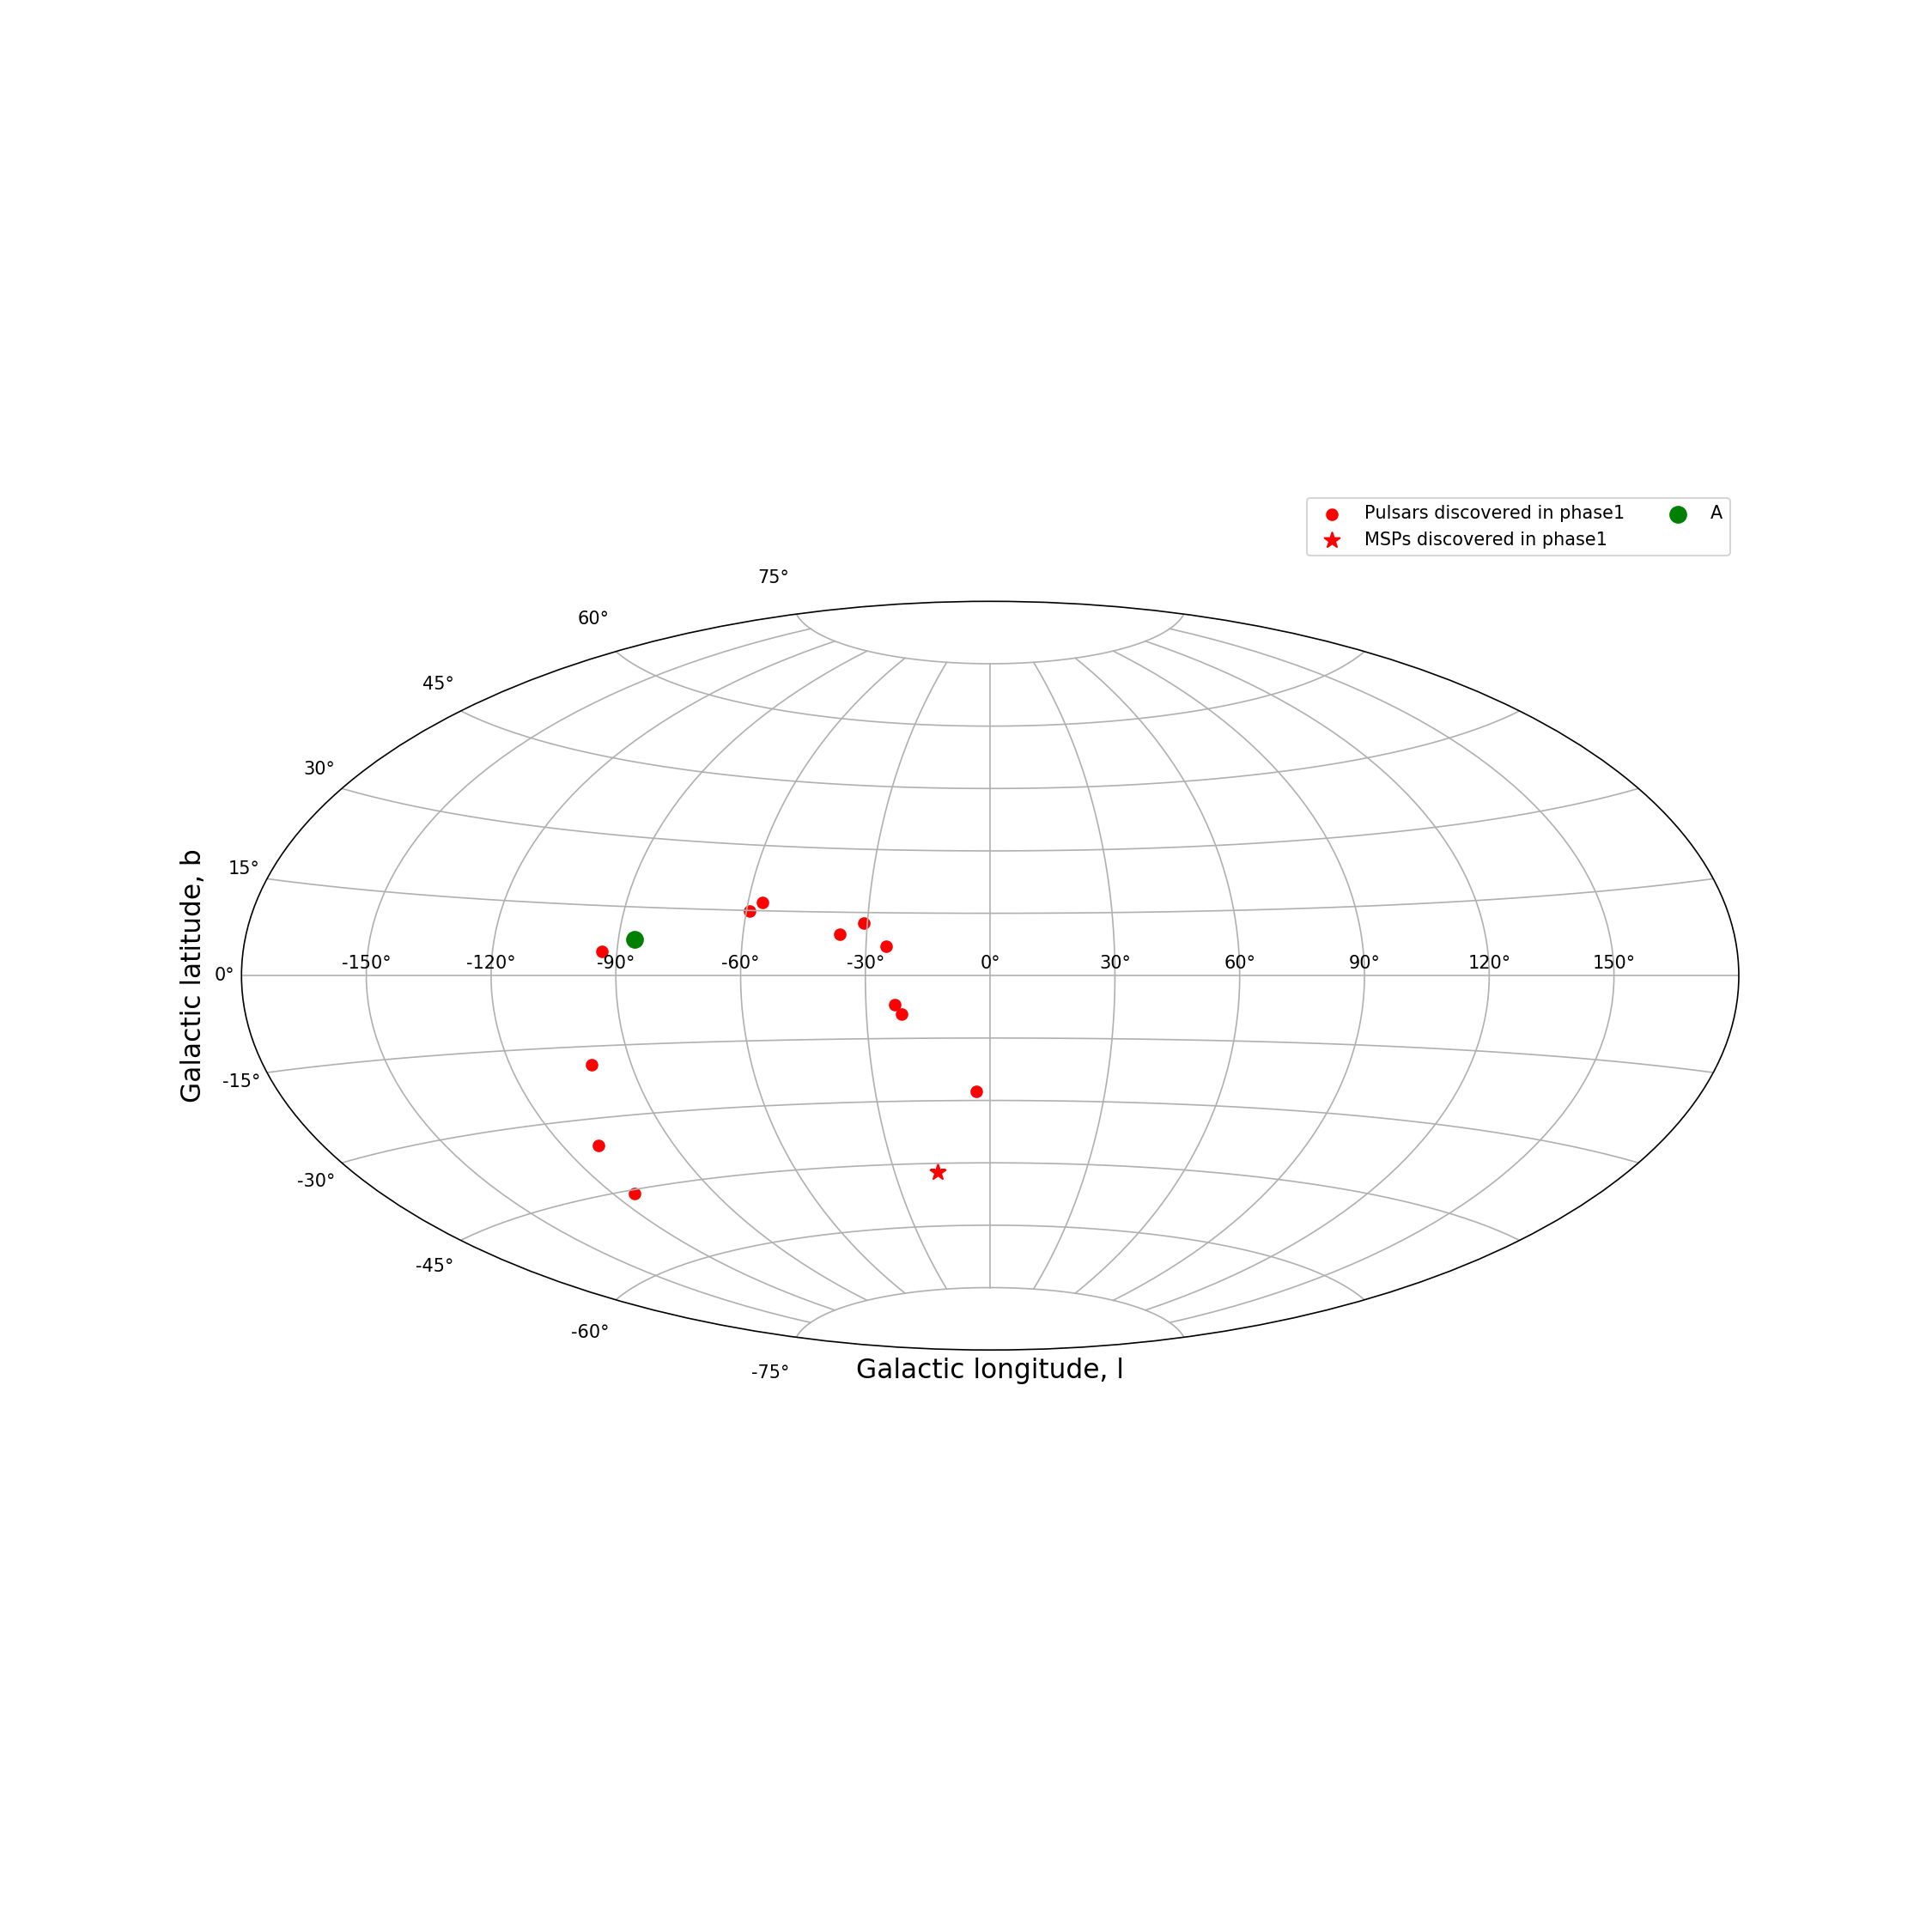

In [9]:
ghrss_obj = GHRSS()
ghrss_obj.accept_choice()